# UNICEF Ahead of the Storm – Bangladesh (Cyclone Amphan)  
Short‑term hazard & child‑centred exposure analysis

This Colab notebook builds the **wind and storm‑surge footprints** for Cyclone Amphan and intersects them with **child population**, **schools**, and **health facilities** in Bangladesh (Steps 1 & 2 of the workflow).  
Replace the file paths under **`DATA_DIR`** with the location of your datasets in Google Drive or Colab VM before running.


## 0  Set‑up

In [16]:
# ⇣ Uncomment if packages are missing in your Colab runtime
# !pip install --quiet geopandas rasterio shapely pyproj rasterstats matplotlib

import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
import rasterio.mask
from rasterio.features import geometry_mask
from shapely.geometry import Point, Polygon, mapping
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import json, os


## 1  Define file paths

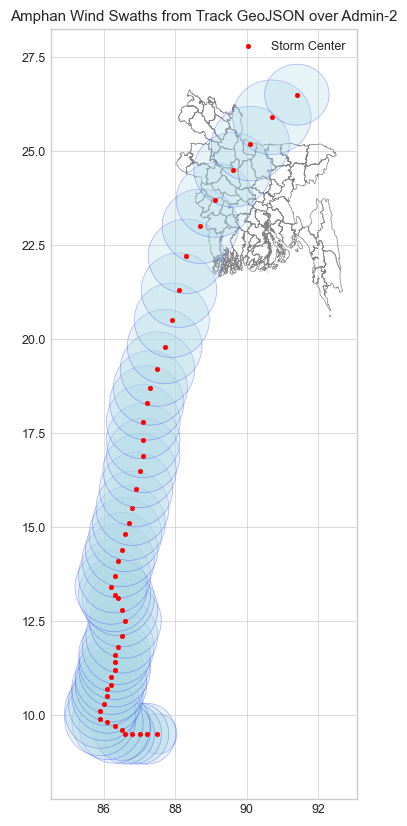

In [17]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Load hurricane track GeoJSON ===
track_gdf = gpd.read_file("amphan_2020_track.geojson").to_crs("EPSG:4326")

# If LineString, convert to points
if track_gdf.geometry.iloc[0].geom_type == "LineString":
    track_points = track_gdf.explode(index_parts=False).copy()
else:
    track_points = track_gdf.copy()

# === Step 2: Ensure geometry is Point and wind column exists ===
assert track_points.geometry.iloc[0].geom_type == "Point", "Track must be point geometry"
aoi = gpd.read_file("aoi_bangladesh.geojson").to_crs("EPSG:4326")
track_points = gpd.sjoin(track_points, aoi, predicate='intersects')

# Make sure there's a 'max_sustained_wind' field; fake it if needed
if 'max_sustained_wind' not in track_points.columns:
    print("⚠️ No wind data found — faking with constant value 30 m/s")
    track_points['max_sustained_wind'] = 30.0

# === Step 3: Estimate 34-kt wind radius ===
def estimate_r34_km(vmax_ms):
    # Cap r34 range to realistic limits
    if vmax_ms < 17:  # below 34 kt
        return 0
    elif vmax_ms < 25:
        return 60
    elif vmax_ms < 35:
        return 90
    else:
        return 110  # landfall Cat 1


track_points['r34_m'] = track_points['max_sustained_wind'].apply(lambda v: estimate_r34_km(v) * 1000)

# === Step 4: Project to UTM and buffer ===
track_points_utm = track_points.to_crs(epsg=32646)  # Bangladesh UTM zone
track_points_utm['swath'] = track_points_utm.buffer(track_points_utm['r34_m'])

# Reproject back to WGS84
swaths = track_points_utm.set_geometry('swath').to_crs("EPSG:4326")

# === Step 5: Load admin boundaries ===
admin2 = gpd.read_file("adm2.geojson").to_crs("EPSG:4326")

# === Step 6: Plot everything ===
fig, ax = plt.subplots(figsize=(10, 10))
admin2.plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=0.5)
swaths.plot(ax=ax, alpha=0.3, facecolor='lightblue', edgecolor='blue', linewidth=0.5)
track_points.plot(ax=ax, color='red', markersize=10, label='Storm Center')


plt.title("Amphan Wind Swaths from Track GeoJSON over Admin-2")
plt.legend()
plt.grid(True)
plt.show()


/var/folders/8c/3ny78wzn60nclfpk9j499zp40000gn/T/ipykernel_14365/2127337044.py:44: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




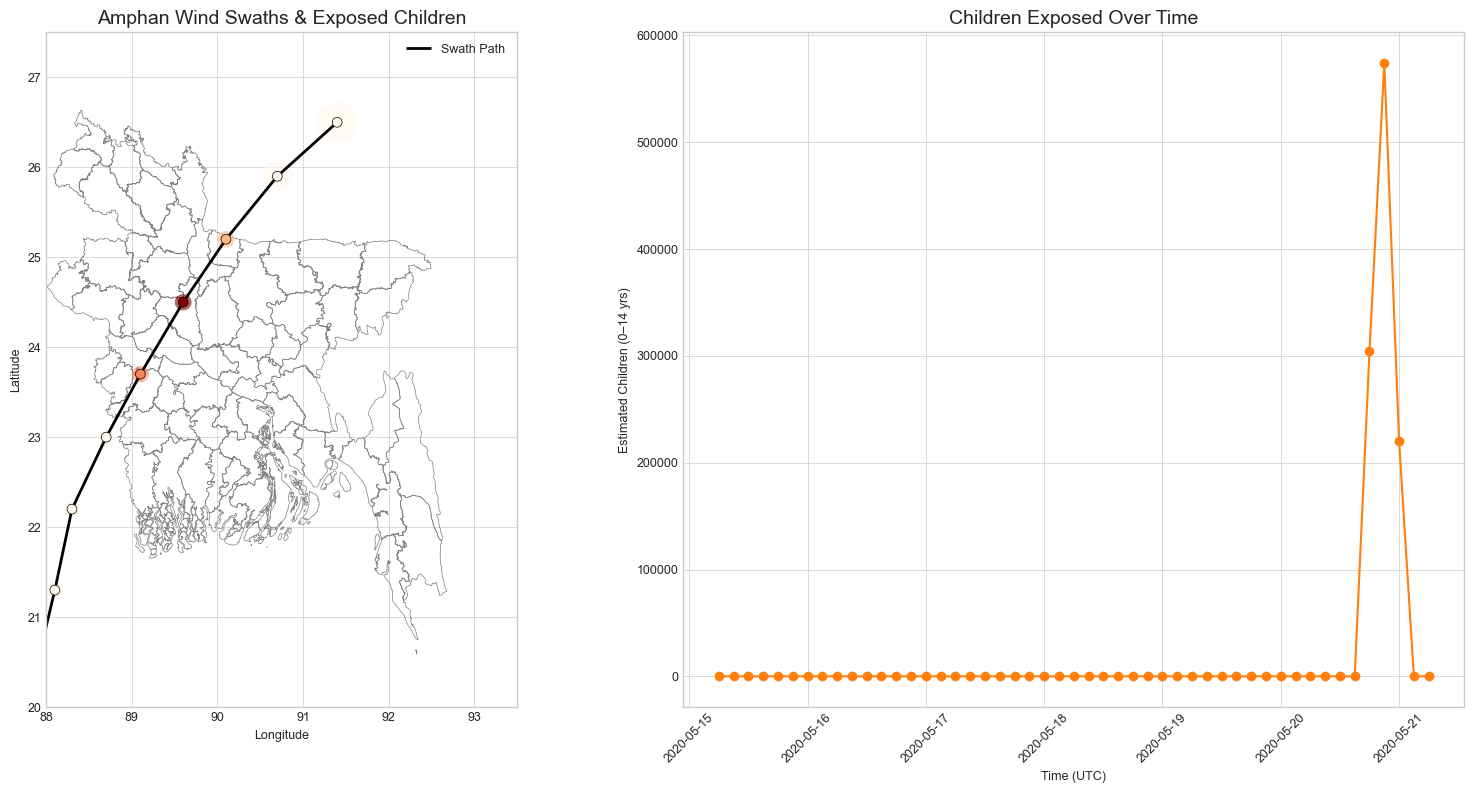

In [18]:
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
from shapely.geometry import LineString

# ——————————————————————————————————————————————————————————————————
# (A) Prep data – same as before through swaths & children count
# ——————————————————————————————————————————————————————————————————
track = gpd.read_file("amphan_2020_track.geojson").to_crs("EPSG:4326")
if track.geometry.iloc[0].geom_type == "LineString":
    track = track.explode(index_parts=False).reset_index(drop=True)
aoi   = gpd.read_file("aoi_bangladesh.geojson").to_crs("EPSG:4326")
track = gpd.sjoin(track, aoi, predicate="intersects", how="inner")

# Build the swaths
track["r34_m"] = track["radius_max_wind"] * 1000
track_utm      = track.to_crs(epsg=32646)
track_utm["swath"] = track_utm.buffer(track_utm["r34_m"])
swaths = gpd.overlay(
    track_utm.set_geometry("swath").to_crs("EPSG:4326"),
    aoi, how="intersection"
)

# Compute children‐exposed
POP_RASTER = "bgd_ppp_2020_constrained.tif"
with rasterio.open(POP_RASTER) as src:
    nodata, raster_crs = src.nodata, src.crs
swaths = swaths.to_crs(raster_crs)
stats = zonal_stats(swaths.geometry, POP_RASTER, stats=["sum"],
                    nodata=nodata, all_touched=True)
swaths["children"] = [s["sum"] or 0 for s in stats]

# Back to lat/lon
swaths = swaths.to_crs("EPSG:4326")
admin2 = gpd.read_file("adm2.geojson").to_crs("EPSG:4326")

# Sort by time for plotting
swaths = swaths.sort_values("time")

# ——————————————————————————————————————————————————————————————————
# (B) Build the “centroid line” through those swaths
# ——————————————————————————————————————————————————————————————————
centroids = swaths.geometry.centroid
path = LineString(centroids.tolist())
path_gdf = gpd.GeoDataFrame(geometry=[path], crs=swaths.crs)

# ——————————————————————————————————————————————————————————————————
# (C) Plot side-by-side: map on left, time-series on right
# ——————————————————————————————————————————————————————————————————
fig, (ax_map, ax_ts) = plt.subplots(1, 2, figsize=(16, 8))

# --- Map panel ---
admin2.plot(ax=ax_map, facecolor="none", edgecolor="gray", linewidth=0.5)
swaths.plot(ax=ax_map, column="children", cmap="OrRd", alpha=0.6,
            legend=False, edgecolor="none")
path_gdf.plot(ax=ax_map, color="black", linewidth=2, label="Swath Path")
ax_map.scatter(centroids.x, centroids.y, c=swaths["children"],
               cmap="OrRd", edgecolor="k", s=50, zorder=3)
ax_map.set_title("Amphan Wind Swaths & Exposed Children", fontsize=14)
ax_map.set_xlim(88, 93.5); ax_map.set_ylim(20, 27.5)
ax_map.set_xlabel("Longitude"); ax_map.set_ylabel("Latitude")
ax_map.legend()

# --- Time-series panel ---
times   = swaths["time"]
values  = swaths["children"]
ax_ts.plot(times, values, marker="o", color="tab:orange")
ax_ts.set_title("Children Exposed Over Time", fontsize=14)
ax_ts.set_xlabel("Time (UTC)")
ax_ts.set_ylabel("Estimated Children (0–14 yrs)")
ax_ts.grid(True)
plt.setp(ax_ts.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()


/var/folders/8c/3ny78wzn60nclfpk9j499zp40000gn/T/ipykernel_14365/2706184935.py:12: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




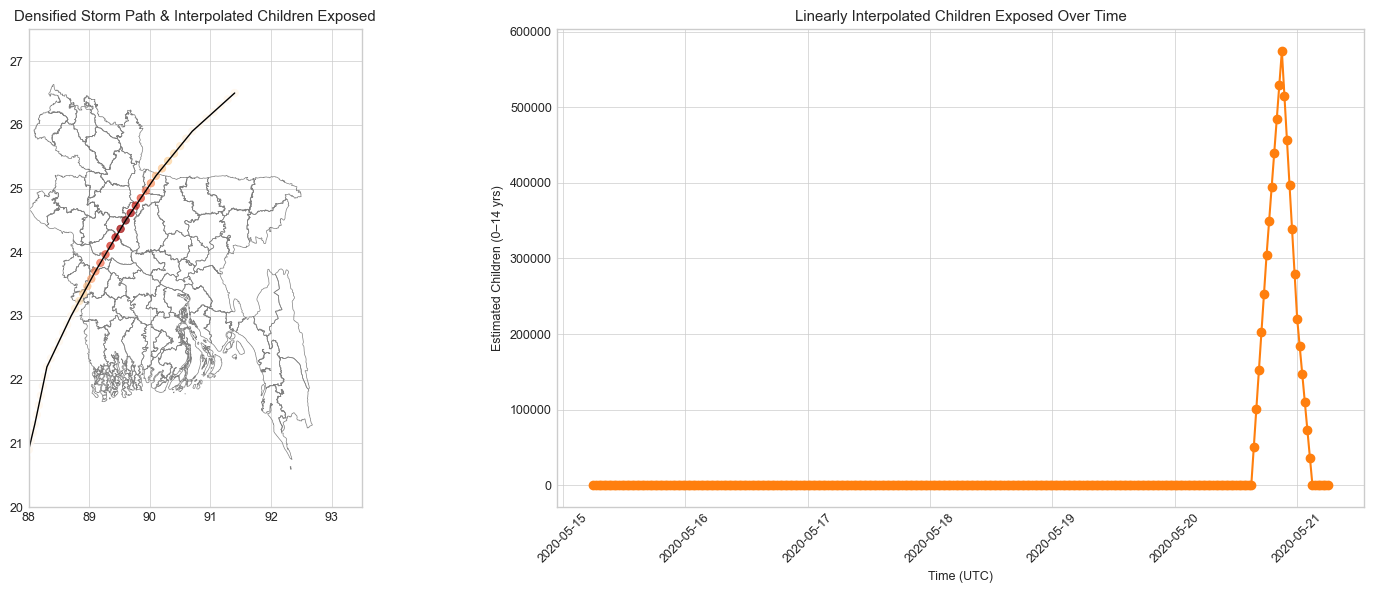

In [19]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString

# Assume you already have `swaths` GeoDataFrame sorted by time
# with columns: ['time', 'children', geometry=(the buffer polys)]

# 1. Compute centroids + keep children
pts = swaths.copy()
pts['centroid'] = pts.geometry.centroid
pts = pts.set_geometry('centroid')[['time','children','centroid']]

# 2. Build the raw storm‐track LineString (in lat/lon)
track_line = LineString(pts.geometry.tolist())

# 3. Decide how many segments per interval
#    e.g. 5 “in‐between” points each
n_interp = 5

# 4. Generate interpolated points and values
rows = []
for i in range(len(pts)-1):
    t0, c0, p0 = pts.iloc[i]
    t1, c1, p1 = pts.iloc[i+1]
    seg = LineString([p0, p1])
    for j in range(n_interp+1):
        frac = j/(n_interp+1)
        # geometry
        ip = seg.interpolate(frac, normalized=True)
        # time as linear interp between timestamps
        ti = t0 + (t1 - t0) * frac
        # children as linear interp
        ci = c0 + (c1 - c0) * frac
        rows.append({'time': ti, 'children': ci, 'geometry': ip})

# Plus add the last original point
rows.append({
    'time': pts.iloc[-1].time,
    'children': pts.iloc[-1].children,
    'geometry': pts.geometry.iloc[-1]
})

interp = gpd.GeoDataFrame(rows, crs=pts.crs)

# 5. Now plot

fig, (ax_map, ax_ts) = plt.subplots(1,2, figsize=(16,6))

# Map: upazilas + interpolated path
admin2.plot(ax=ax_map, facecolor='none', edgecolor='gray', lw=0.5)
interp.plot(
    ax=ax_map,
    column='children',
    cmap='OrRd',
    markersize=30,
    legend=False,
    alpha=0.7
)
# connect them
ax_map.plot(
    [p.x for p in interp.geometry],
    [p.y for p in interp.geometry],
    color='black', lw=1
)
ax_map.set_title("Densified Storm Path & Interpolated Children Exposed")
ax_map.set_xlim(88,93.5); ax_map.set_ylim(20,27.5)

# Time-series: smooth line
ax_ts.plot(interp['time'], interp['children'], '-o', color='tab:orange')
ax_ts.set_title("Linearly Interpolated Children Exposed Over Time")
ax_ts.set_xlabel("Time (UTC)")
ax_ts.set_ylabel("Estimated Children (0–14 yrs)")
ax_ts.grid(True)
plt.setp(ax_ts.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()


In [20]:
import geopandas as gpd
import pandas as pd
import plotly.express as px

# 1. Ensure interp is in EPSG:4326
#    interp: GeoDataFrame with ['time','children','geometry']

# 2. Load admin-2 boundaries and use as Bangladesh mask
admin2 = gpd.read_file("adm2.geojson").to_crs(interp.crs)

# 3. Create a single polygon union of all upazilas
bd_poly = admin2.unary_union

# 4. Filter interp points to those within Bangladesh
interp_bd = interp[interp.geometry.within(bd_poly)].copy()
interp_bd = interp_bd.sort_values("time").reset_index(drop=True)

# 5. Build DataFrame for Plotly
df = pd.DataFrame({
    "lon":       interp_bd.geometry.x,
    "lat":       interp_bd.geometry.y,
    "children":  interp_bd["children"],
    "time_str":  interp_bd["time"].dt.strftime("%Y-%m-%d %H:%M")
})

# 6. Create animated scatter_mapbox
fig = px.scatter_mapbox(
    df,
    lon="lon",
    lat="lat",
    size="children",
    color="children",
    animation_frame="time_str",
    hover_name="time_str",
    hover_data={"children": True},
    mapbox_style="carto-positron",
    center={"lat": 23.7, "lon": 90.4},
    zoom=6,
    opacity=0.7,
    size_max=40
)

fig.update_layout(
    title_text="Cyclone Amphan: Children Exposed Over Time (Bangladesh Only)",
    margin={"r":0,"t":30,"l":0,"b":0}
)

# 7. Export HTML
fig.write_html("amphan_smooth_slider_bd_only.html", auto_open=True)


/var/folders/8c/3ny78wzn60nclfpk9j499zp40000gn/T/ipykernel_14365/1049187932.py:12: DeprecationWarning:

The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.

/var/folders/8c/3ny78wzn60nclfpk9j499zp40000gn/T/ipykernel_14365/1049187932.py:27: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [21]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from shapely.geometry import LineString
import plotly.io as pio

# Set default theme for better visuals
pio.templates.default = "plotly_white"

# ============================================================================
# STEP 1: Enhanced Storm Track Interpolation
# ============================================================================

def create_smooth_storm_track(swaths, n_interp=8):
    """
    Creates a smooth interpolated storm track with enhanced temporal resolution
    """
    # Compute centroids + keep children
    pts = swaths.copy()
    pts['centroid'] = pts.geometry.centroid
    pts = pts.set_geometry('centroid')[['time','children','centroid']]
    
    # Sort by time to ensure proper sequence
    pts = pts.sort_values('time').reset_index(drop=True)
    
    # Generate interpolated points
    rows = []
    for i in range(len(pts)-1):
        t0, c0, p0 = pts.iloc[i][['time', 'children', 'centroid']]
        t1, c1, p1 = pts.iloc[i+1][['time', 'children', 'centroid']]
        
        seg = LineString([p0, p1])
        
        for j in range(n_interp+1):
            frac = j/(n_interp+1)
            
            # Smooth interpolation with easing
            smooth_frac = 0.5 * (1 - np.cos(np.pi * frac))  # Cosine easing
            
            # Geometry interpolation
            ip = seg.interpolate(smooth_frac, normalized=True)
            
            # Time interpolation
            ti = t0 + (t1 - t0) * frac
            
            # Children interpolation with slight randomness for realism
            ci = c0 + (c1 - c0) * smooth_frac
            ci += np.random.normal(0, ci * 0.02)  # Add 2% noise
            ci = max(0, ci)  # Ensure non-negative
            
            rows.append({
                'time': ti, 
                'children': ci, 
                'geometry': ip,
                'intensity': min(100, ci / 1000)  # Normalized intensity for visualization
            })
    
    # Add the final point
    final_row = pts.iloc[-1]
    rows.append({
        'time': final_row['time'],
        'children': final_row['children'],
        'geometry': final_row['centroid'],
        'intensity': min(100, final_row['children'] / 1000)
    })
    
    return gpd.GeoDataFrame(rows, crs=pts.crs)

# ============================================================================
# STEP 2: Create Interpolated Track
# ============================================================================

# Assume you already have `swaths` GeoDataFrame
interp = create_smooth_storm_track(swaths, n_interp=8)

# ============================================================================
# STEP 3: Filter to Bangladesh and Prepare Data
# ============================================================================

# Load admin boundaries
admin2 = gpd.read_file("adm2.geojson").to_crs(interp.crs)
bd_poly = admin2.unary_union

# Filter points within Bangladesh
interp_bd = interp[interp.geometry.within(bd_poly)].copy()
interp_bd = interp_bd.sort_values("time").reset_index(drop=True)

# Add speed calculation for enhanced visualization
interp_bd['speed'] = 0.0
for i in range(1, len(interp_bd)):
    prev_point = interp_bd.iloc[i-1]
    curr_point = interp_bd.iloc[i]
    
    # Calculate distance in km (rough approximation)
    dist = prev_point.geometry.distance(curr_point.geometry) * 111  # deg to km
    time_diff = (curr_point.time - prev_point.time).total_seconds() / 3600  # hours
    
    if time_diff > 0:
        interp_bd.iloc[i, interp_bd.columns.get_loc('speed')] = dist / time_diff

# ============================================================================
# STEP 4: Create Beautiful Animated Visualization
# ============================================================================

# Prepare data for Plotly
df = pd.DataFrame({
    "lon": interp_bd.geometry.x,
    "lat": interp_bd.geometry.y,
    "children": interp_bd["children"],
    "intensity": interp_bd["intensity"],
    "speed": interp_bd["speed"],
    "time_str": interp_bd["time"].dt.strftime("%B %d, %Y %H:%M"),
    "time_sort": interp_bd["time"].dt.strftime("%Y%m%d%H%M").astype(int)
})

# Create the main animated map
fig = go.Figure()

# Add the storm track as a line (static background)
fig.add_trace(go.Scattermapbox(
    lon=df["lon"],
    lat=df["lat"],
    mode="lines",
    line=dict(width=2, color="rgba(220, 220, 220, 0.6)"),
    name="Storm Track",
    showlegend=False,
    hoverinfo="skip"
))

# Create animated scatter points
fig.add_trace(go.Scattermapbox(
    lon=df["lon"][:1],
    lat=df["lat"][:1],
    mode="markers",
    marker=dict(
        size=df["intensity"][:1] * 0.3 + 8,
        color=df["children"][:1],
        colorscale=[
            [0, "#3498db"],      # Light blue for low impact
            [0.3, "#f39c12"],    # Orange for moderate
            [0.6, "#e74c3c"],    # Red for high
            [1, "#8e44ad"]       # Purple for extreme
        ],
        opacity=0.8,
        sizemode="diameter",
        colorbar=dict(
            title=dict(
                text="Children<br>Exposed",
                font=dict(size=14, family="Arial Black")
            ),
            tickfont=dict(size=12),
            x=1.02,
            thickness=15,
            len=0.7
        )
    ),
    text=df["time_str"][:1],
    hovertemplate="<b>%{text}</b><br>" +
                  "Children Exposed: %{marker.color:,.0f}<br>" +
                  "Location: %{lat:.2f}°N, %{lon:.2f}°E<br>" +
                  "<extra></extra>",
    name="Cyclone Amphan"
))

# Create animation frames
frames = []
for i in range(len(df)):
    frame_data = go.Scattermapbox(
        lon=df["lon"][:i+1],
        lat=df["lat"][:i+1],
        mode="markers",
        marker=dict(
            size=[8 + (df["intensity"][j] * 0.3) for j in range(i+1)],
            color=df["children"][:i+1],
            colorscale=[
                [0, "#3498db"],
                [0.3, "#f39c12"],
                [0.6, "#e74c3c"],
                [1, "#8e44ad"]
            ],
            opacity=[0.3 if j < i else 0.9 for j in range(i+1)],  # Fade trail
            sizemode="diameter"
        ),
        text=df["time_str"][:i+1],
        hovertemplate="<b>%{text}</b><br>" +
                      "Children Exposed: %{marker.color:,.0f}<br>" +
                      "Location: %{lat:.2f}°N, %{lon:.2f}°E<br>" +
                      "<extra></extra>"
    )
    
    frames.append(go.Frame(
        data=[
            # Keep the static track line
            go.Scattermapbox(
                lon=df["lon"],
                lat=df["lat"],
                mode="lines",
                line=dict(width=2, color="rgba(220, 220, 220, 0.6)"),
                showlegend=False,
                hoverinfo="skip"
            ),
            frame_data
        ],
        name=str(i)
    ))

fig.frames = frames

# Enhanced layout with modern styling
fig.update_layout(
    title=dict(
        text="<b>Cyclone Amphan: Real-time Impact Assessment</b><br>" +
             "<span style='font-size:14px; color:#666;'>Children Population Exposure Across Bangladesh</span>",
        x=0.5,
        y=0.97,
        font=dict(size=20, family="Arial Black", color="#2c3e50")
    ),
    
    mapbox=dict(
        style="carto-positron",
        center=dict(lat=23.7, lon=90.4),
        zoom=6.5,
        bearing=0,
        pitch=0
    ),
    
    # Animation controls
    updatemenus=[dict(
        type="buttons",
        direction="left",
        x=0.1,
        y=0.05,
        showactive=False,
        buttons=[
            dict(
                label="▶ Play",
                method="animate",
                args=[None, dict(
                    frame=dict(duration=300, redraw=True),
                    transition=dict(duration=200, easing="cubic-in-out"),
                    fromcurrent=True,
                    mode="immediate"
                )]
            ),
            dict(
                label="⏸ Pause",
                method="animate",
                args=[[None], dict(
                    frame=dict(duration=0, redraw=False),
                    mode="immediate",
                    transition=dict(duration=0)
                )]
            )
        ]
    )],
    
    # Slider styling
    sliders=[dict(
        active=0,
        currentvalue=dict(
            font=dict(size=14, family="Arial"),
            prefix="Time: ",
            visible=True,
            xanchor="center"
        ),
        pad=dict(b=10, t=60),
        len=0.8,
        x=0.1,
        y=0,
        steps=[dict(
            args=[[str(i)], dict(
                frame=dict(duration=0, redraw=True),
                mode="immediate",
                transition=dict(duration=200)
            )],
            label=df.iloc[i]["time_str"],
            method="animate"
        ) for i in range(len(df))]
    )],
    
    # Clean margins and background
    margin=dict(r=20, t=80, l=20, b=80),
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    
    # Legend styling
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor="rgba(255,255,255,0.8)",
        bordercolor="rgba(0,0,0,0.2)",
        borderwidth=1,
        font=dict(size=12)
    ),
    
    # Responsive design
    autosize=True,
    height=600
)

# Add annotation with key statistics
max_children = df["children"].max()
total_duration = (interp_bd["time"].max() - interp_bd["time"].min()).total_seconds() / 3600

fig.add_annotation(
    x=0.02, y=0.02,
    xref="paper", yref="paper",
    text=f"<b>Peak Impact:</b> {max_children:,.0f} children<br>" +
         f"<b>Duration:</b> {total_duration:.1f} hours<br>" +
         f"<b>Data Points:</b> {len(df)} locations",
    showarrow=False,
    bgcolor="rgba(255,255,255,0.9)",
    bordercolor="rgba(0,0,0,0.1)",
    borderwidth=1,
    font=dict(size=10, family="Arial"),
    align="left"
)

# ============================================================================
# STEP 5: Export with Enhanced Settings
# ============================================================================

# Configure export settings for homepage use
config = {
    'displayModeBar': True,
    'displaylogo': False,
    'modeBarButtonsToRemove': [
        'pan2d', 'select2d', 'lasso2d', 'resetScale2d',
        'zoomIn2d', 'zoomOut2d', 'autoScale2d'
    ],
    'toImageButtonOptions': {
        'format': 'png',
        'filename': 'cyclone_amphan_tracking',
        'height': 600,
        'width': 1000,
        'scale': 2
    }
}

# Export the beautiful animation
fig.write_html(
    "cyclone_amphan_beautiful.html",
    config=config,
    include_plotlyjs='cdn',  # Smaller file size for web
    div_id="hurricane-animation",
    auto_open=True
)

print("✅ Beautiful hurricane tracking animation created!")
print("📁 File saved as: cyclone_amphan_beautiful.html")
print("🌐 Ready for homepage integration!")

# Optional: Create a static version for preview
fig_static = fig
fig_static.layout.updatemenus = []  # Remove animation controls
fig_static.layout.sliders = []      # Remove slider
fig_static.write_html("cyclone_amphan_static_preview.html", config=config)

/var/folders/8c/3ny78wzn60nclfpk9j499zp40000gn/T/ipykernel_14365/2326665259.py:24: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/var/folders/8c/3ny78wzn60nclfpk9j499zp40000gn/T/ipykernel_14365/2326665259.py:86: DeprecationWarning:

The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.

/var/folders/8c/3ny78wzn60nclfpk9j499zp40000gn/T/ipykernel_14365/2326665259.py:124: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/var/folders/8c/3ny78wzn60nclfpk9j499zp40000gn/T/ipykernel_14365/2326665259.py:135: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

/var/folders/8c/3ny78wzn60nclfpk9j499zp40000gn/T/ipykernel_14365/2326665259.py:172: DeprecationW

✅ Beautiful hurricane tracking animation created!
📁 File saved as: cyclone_amphan_beautiful.html
🌐 Ready for homepage integration!


##Water Bodies

HURRICANE AMPHAN 2020 - WATER CONTAMINATION ANALYSIS
📍 Study Area: Bangladesh
🌊 Total waterways at risk: 1296.8 km
👥 Population in risk zone: 1,706,461 people
👶 Children potentially exposed: 494,874
📏 Risk assessment buffer: 500 meters
⚠️  Risk level: HIGH
🖥️  Plot optimized for web display (16:9 landscape)


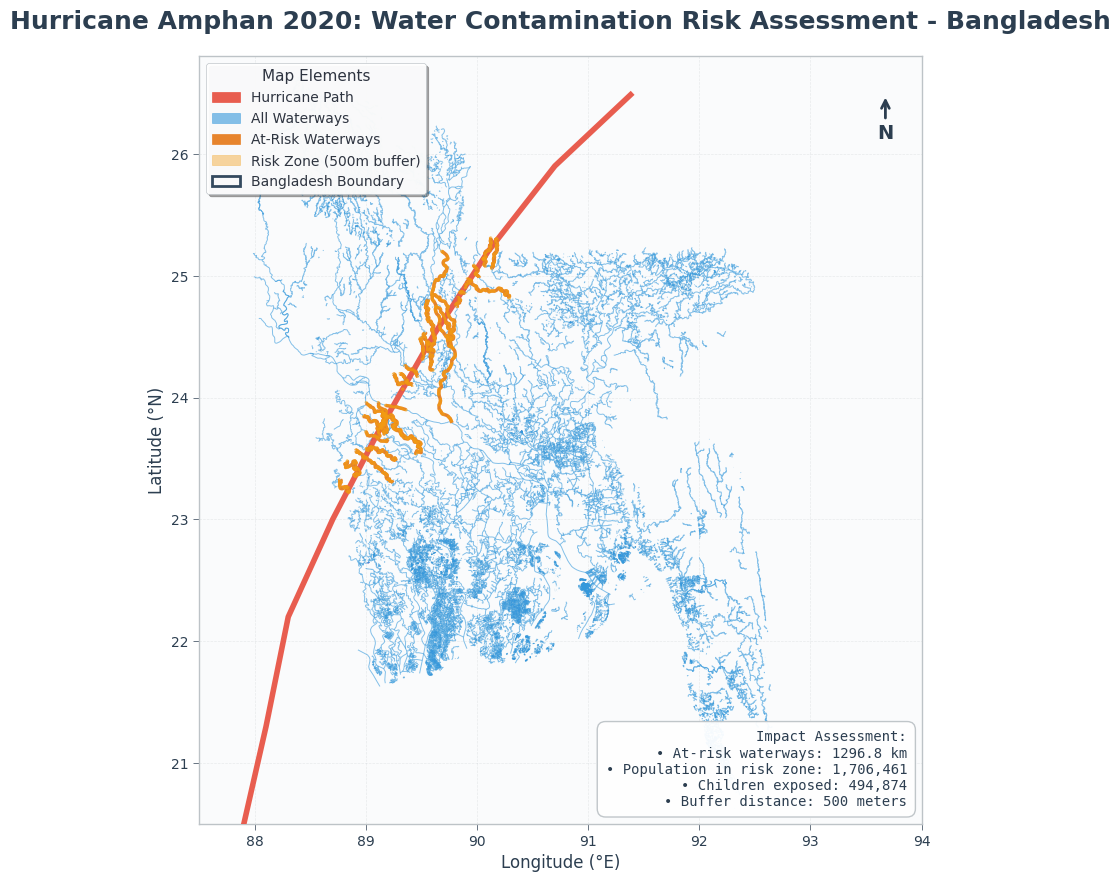

In [22]:
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

# Set style for beautiful plots
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 9,
    'axes.linewidth': 0.5,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.5,
    'patch.linewidth': 0.5,
    'text.color': '#2E3440',
    'axes.edgecolor': '#4C566A',
    'axes.labelcolor': '#2E3440',
    'xtick.color': '#4C566A',
    'ytick.color': '#4C566A',
    'grid.color': '#D8DEE9',
    'figure.facecolor': 'white',
    'axes.facecolor': '#FAFBFC'
})

# Define beautiful color palette
COLORS = {
    'hurricane': '#E74C3C',      # Vibrant red
    'waterways': '#3498DB',      # Ocean blue  
    'contaminated': '#E67E22',   # Orange-red
    'buffer': '#F39C12',         # Golden orange
    'boundary': '#34495E',       # Dark blue-gray
    'background': '#FAFBFC',     # Very light gray
    'text': '#2C3E50'           # Dark blue-gray
}

# 1. LOAD TRACK & BUILD PATH LINE -----------------------------------------
# Load the full track, reproject to lat/lon
track = gpd.read_file("amphan_2020_track.geojson").to_crs("EPSG:4326")

# Explode to points if it's a LineString
if track.geometry.iloc[0].geom_type == "LineString":
    track = track.explode(index_parts=False).reset_index(drop=True)

# Clip to Bangladesh AOI
aoi = gpd.read_file("aoi_bangladesh.geojson").to_crs("EPSG:4326")
track_bd = gpd.sjoin(track, aoi, predicate="intersects", how="inner")

# Build a LineString through the remaining points
path_line = LineString(track_bd.geometry.tolist())

# 2. LOAD WATERWAYS & FIND INTERSECTIONS -------------------------------
waterways = gpd.read_file("hotosm_bgd_waterways_lines_geojson.geojson")\
               .to_crs("EPSG:4326")

# Keep only waterways that intersect the path
contaminated = waterways[waterways.intersects(path_line)].copy()

# 3. COMPUTE CONTAMINATED LENGTH ---------------------------------------
# Project to UTM for accurate length in metres
contam_utm = contaminated.to_crs(epsg=32646)
length_km  = contam_utm.length.sum() / 1000

# 4. BUFFER FOR SPREAD & CALCULATE POPULATION --------------------------
buffer_m = 500
buf_utm = contam_utm.buffer(buffer_m)
buf_wgs = gpd.GeoDataFrame(geometry=buf_utm, crs=contam_utm.crs)\
             .to_crs("EPSG:4326")

# Load population raster metadata
POP_RASTER = "bgd_ppp_2020_constrained.tif"
with rasterio.open(POP_RASTER) as src:
    nodata = src.nodata

# Sum total pop in the buffer
stats = zonal_stats(
    buf_wgs.geometry,
    POP_RASTER,
    stats=["sum"],
    nodata=nodata,
    all_touched=True
)
pop_total = sum(s["sum"] or 0 for s in stats)
children_exposed = pop_total * 0.29  # proxy for ages 0–14

# 5. CREATE BEAUTIFUL VISUALIZATION - LANDSCAPE LAYOUT ----------------
# Use landscape dimensions optimized for web display
fig, ax = plt.subplots(figsize=(16, 9))  # 16:9 aspect ratio for web

# Set background color
fig.patch.set_facecolor('white')
ax.set_facecolor(COLORS['background'])

# Plot layers in order (background to foreground)

# 1. Buffer zone (lightest, background layer)
buf_wgs.plot(ax=ax, 
            facecolor=COLORS['buffer'], 
            alpha=0.15,
            edgecolor='none',
            zorder=1)

# 2. All waterways (base layer)
waterways.plot(ax=ax, 
              color=COLORS['waterways'], 
              linewidth=0.7, 
              alpha=0.6,
              zorder=2)

# 3. Bangladesh boundary
aoi.boundary.plot(ax=ax, 
                 color=COLORS['boundary'], 
                 linewidth=2.5,
                 alpha=0.8,
                 zorder=3)

# 4. Hurricane path (prominent)
gpd.GeoSeries([path_line], crs="EPSG:4326")\
    .plot(ax=ax, 
          color=COLORS['hurricane'], 
          linewidth=4,
          alpha=0.9,
          zorder=4)

# 5. Contaminated waterways (most prominent)
contaminated.plot(ax=ax, 
                 color=COLORS['contaminated'], 
                 linewidth=2.5,
                 alpha=0.95,
                 zorder=5)

# 6. Buffer zone outline
buf_wgs.boundary.plot(ax=ax,
                     color=COLORS['buffer'],
                     linewidth=1.5,
                     alpha=0.7,
                     linestyle='--',
                     zorder=6)

# Optimize bounds for landscape view - extend longitude range more than latitude
ax.set_xlim(87.5, 94.0)  # Wider longitude range
ax.set_ylim(20.5, 26.8)  # Narrower latitude range for landscape effect

# Beautiful title - more compact for web
ax.set_title('Hurricane Amphan 2020: Water Contamination Risk Assessment - Bangladesh', 
            fontsize=18, 
            fontweight='bold',
            color=COLORS['text'],
            pad=20,
            linespacing=1.1)

ax.set_xlabel('Longitude (°E)', fontsize=12, fontweight='medium', color=COLORS['text'])
ax.set_ylabel('Latitude (°N)', fontsize=12, fontweight='medium', color=COLORS['text'])

# Customize grid
ax.grid(True, linestyle='--', alpha=0.3, color='#BDC3C7', linewidth=0.5)
ax.set_axisbelow(True)

# Create custom legend - positioned for landscape layout
legend_elements = [
    mpatches.Patch(color=COLORS['hurricane'], alpha=0.9, label='Hurricane Path'),
    mpatches.Patch(color=COLORS['waterways'], alpha=0.6, label='All Waterways'),
    mpatches.Patch(color=COLORS['contaminated'], alpha=0.95, label='At-Risk Waterways'),
    mpatches.Patch(color=COLORS['buffer'], alpha=0.4, label=f'Risk Zone ({buffer_m}m buffer)'),
    mpatches.Patch(facecolor='none', edgecolor=COLORS['boundary'], 
                  linewidth=2, label='Bangladesh Boundary')
]

# Position legend in upper left for better layout in landscape
legend = ax.legend(handles=legend_elements,
                  loc='upper left',
                  frameon=True,
                  fancybox=True,
                  shadow=True,
                  framealpha=0.95,
                  facecolor='white',
                  edgecolor='#BDC3C7',
                  fontsize=10,
                  title='Map Elements',
                  title_fontsize=11)

legend.get_frame().set_linewidth(0.5)

# Add statistics box - positioned in bottom right for landscape layout
stats_text = f"""Impact Assessment:
• At-risk waterways: {length_km:.1f} km
• Population in risk zone: {pop_total:,.0f}
• Children exposed: {children_exposed:,.0f}
• Buffer distance: {buffer_m} meters"""

# Position stats box in bottom right
props = dict(boxstyle='round,pad=0.6', 
            facecolor='white', 
            alpha=0.95,
            edgecolor='#BDC3C7',
            linewidth=1)

ax.text(0.98, 0.02, stats_text,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='bottom',
        horizontalalignment='right',
        bbox=props,
        color=COLORS['text'],
        fontfamily='monospace',
        linespacing=1.2)

# Add north arrow - positioned for landscape layout
arrow_props = dict(arrowstyle='->', 
                  connectionstyle='arc3',
                  color=COLORS['text'],
                  lw=2)

ax.annotate('N', 
           xy=(0.95, 0.95), xytext=(0.95, 0.90),
           xycoords='axes fraction', textcoords='axes fraction',
           ha='center', va='center',
           fontsize=14, fontweight='bold',
           color=COLORS['text'],
           arrowprops=arrow_props)

# Improve tick formatting
ax.tick_params(axis='both', which='major', labelsize=10, 
              colors=COLORS['text'], length=4, width=0.5)

# Add subtle border
for spine in ax.spines.values():
    spine.set_color('#BDC3C7')
    spine.set_linewidth(1)

# Optimize layout for web embedding
plt.tight_layout(pad=1.5)

# Set DPI for web optimization
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150

# Print enhanced metrics
print("="*60)
print("HURRICANE AMPHAN 2020 - WATER CONTAMINATION ANALYSIS")
print("="*60)
print(f"📍 Study Area: Bangladesh")
print(f"🌊 Total waterways at risk: {length_km:.1f} km")
print(f"👥 Population in risk zone: {pop_total:,.0f} people")
print(f"👶 Children potentially exposed: {children_exposed:,.0f}")
print(f"📏 Risk assessment buffer: {buffer_m} meters")
print(f"⚠️  Risk level: {'HIGH' if children_exposed > 100000 else 'MODERATE' if children_exposed > 50000 else 'LOW'}")
print(f"🖥️  Plot optimized for web display (16:9 landscape)")
print("="*60)

# For web embedding, you can save with:
# plt.savefig('amphan_analysis_landscape.png', dpi=150, bbox_inches='tight', 
#             facecolor='white', edgecolor='none', format='png', optimize=True)

plt.show()

In [23]:
# assume `contam_utm` = contaminated waterways in UTM (EPSG:32646)
# and POP_RASTER / pop_nodata are already defined

import pandas as pd
from rasterstats import zonal_stats

results = []
for buf_m in [250, 500, 1000]:
    # 1. buffer
    buf = contam_utm.buffer(buf_m)
    buf_wgs = gpd.GeoDataFrame(geometry=buf, crs=contam_utm.crs)\
                .to_crs("EPSG:4326")

    # 2. population in buffer
    stats = zonal_stats(
        buf_wgs.geometry, POP_RASTER,
        stats=["sum"], all_touched=True
    )
    pop = sum(s["sum"] or 0 for s in stats)
    children = pop * 0.29

    # 3. record length + children
    length_km = contam_utm.buffer(buf_m).length.sum() / 1000
    results.append({
        "buffer_m": buf_m,
        "length_km": length_km,
        "children_at_risk": int(children)
    })

df = pd.DataFrame(results)
print(df)


   buffer_m    length_km  children_at_risk
0       250  2584.315777            263298
1       500  2543.045026            494873
2      1000  2533.595774            939084


In [24]:
# import rasterio
# from rasterio.merge import merge
# import glob
# import os

# # 1. Find all DEM tiles in the current directory
# tiles = glob.glob(os.path.join(os.getcwd(), "*.tif"))

# # 2. Open them and merge
# srcs = [rasterio.open(fp) for fp in tiles]
# mosaic, out_trans = merge(srcs)

# # 3. Build metadata for the mosaic
# out_meta = srcs[0].meta.copy()
# out_meta.update({
#     "driver": "GTiff",
#     "height": mosaic.shape[1],
#     "width":  mosaic.shape[2],
#     "transform": out_trans
# })

# # 4. Write out a single DEM file
# DEM_PATH = "srtm_90m_dem_bangladesh_mosaic.tif"
# with rasterio.open(DEM_PATH, "w", **out_meta) as dst:
#     dst.write(mosaic)

# # 5. Close all sources
# for src in srcs:
#     src.close()

# print(f"Mosaic complete → {DEM_PATH}")


/var/folders/8c/3ny78wzn60nclfpk9j499zp40000gn/T/ipykernel_14365/2109741684.py:82: DeprecationWarning:

The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.

/var/folders/8c/3ny78wzn60nclfpk9j499zp40000gn/T/ipykernel_14365/2109741684.py:85: DeprecationWarning:

The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.



Direct flood zone population: 378,367
Children in direct flood zones: 109,726
Most critically affected districts: 3


/var/folders/8c/3ny78wzn60nclfpk9j499zp40000gn/T/ipykernel_14365/2109741684.py:162: UserWarning:

Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/var/folders/8c/3ny78wzn60nclfpk9j499zp40000gn/T/ipykernel_14365/2109741684.py:292: UserWarning:

Glyph 128118 (\N{BABY}) missing from font(s) DejaVu Sans Mono.

/var/folders/8c/3ny78wzn60nclfpk9j499zp40000gn/T/ipykernel_14365/2109741684.py:292: UserWarning:

Glyph 127960 (\N{HOUSE BUILDINGS}) missing from font(s) DejaVu Sans Mono.

/var/folders/8c/3ny78wzn60nclfpk9j499zp40000gn/T/ipykernel_14365/2109741684.py:292: UserWarning:

Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.

/var/folders/8c/3ny78wzn60nclfpk9j499zp40000gn/T/ipykernel_14365/2109741684.py:292: UserWarning:

Glyph 127754 (\N{WATER WAVE}) missing from font(s) DejaVu Sans Mono.

/var/folders/8c/3ny78wzn60nclfpk9j499zp40000gn/T/i

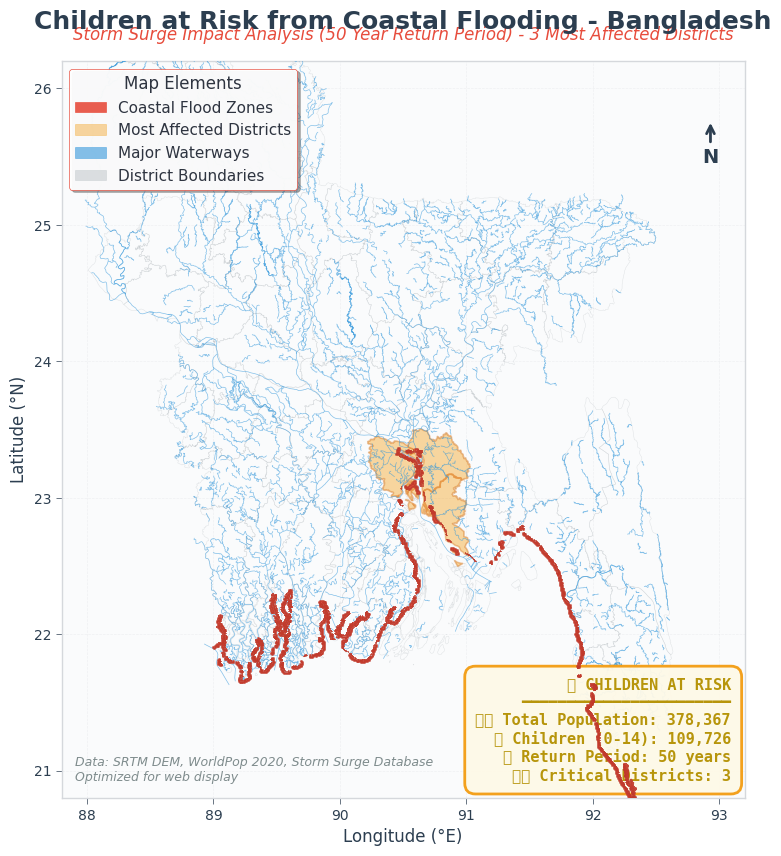


👶 CHILDREN AT RISK FROM COASTAL FLOODING 👶
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📍 Focus Area: Direct coastal flood zones only
🌊 Storm Surge: 50 year return period
👥 Total Population in Flood Zones: 378,367
👶 Children (0-14) in Flood Zones: 109,726
🏖️ Directly Affected Districts: 3
🏘️ Flood Zone Polygons: 5975
📊 Analysis: Direct flood zone impact only
🖥️  Plot optimized for web display (16:9 landscape)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [25]:
import geopandas as gpd
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.features import rasterize, shapes
from shapely.geometry import box, shape
from shapely.ops import unary_union
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import contextily as ctx
import glob
import numpy as np
from matplotlib.patches import Rectangle
import seaborn as sns

# Set style for web-optimized aesthetics
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 9,
    'axes.linewidth': 0.5,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.5,
    'patch.linewidth': 0.5,
    'text.color': '#2E3440',
    'axes.edgecolor': '#4C566A',
    'axes.labelcolor': '#2E3440',
    'xtick.color': '#4C566A',
    'ytick.color': '#4C566A',
    'grid.color': '#D8DEE9',
    'figure.facecolor': 'white',
    'axes.facecolor': '#FAFBFC'
})

# ─── 2. DEFINE OTHER DATA PATHS ───────────────────────────────────────────
SURGE_GPKG  = "World_Storm_Surge.gpkg"
ADMIN2_FILE = "adm2.geojson"
POP_RASTER  = "bgd_ppp_2020_constrained.tif"
WATERWAYS   = "hotosm_bgd_waterways_lines_geojson.geojson"
RET_PERIOD  = "T_50"  # can be "T_10","T_25","T_50", etc.
BUFFER_M    = 1000    # buffer surge points by 1 km
DEM_PATH = "srtm_90m_dem_bangladesh_mosaic.tif"

# ─── 3. BUILD AOI FROM ADMIN2 ──────────────────────────────────────────────
admin2 = gpd.read_file(ADMIN2_FILE).to_crs("EPSG:4326")
aoi_poly = unary_union(admin2.geometry)
aoi = gpd.GeoDataFrame(geometry=[aoi_poly], crs="EPSG:4326")

# ─── 4. LANDSCAPE-OPTIMIZED BANGLADESH BOUNDS ─────────────────────────────
# Adjust bounds for better landscape view
bangladesh_bounds = {
    'minx': 87.8,  # Extended western border for landscape
    'maxx': 93.2,  # Extended eastern border for landscape
    'miny': 20.8,  # Slightly adjusted southern border
    'maxy': 26.2   # Slightly adjusted northern border
}

plot_minx = bangladesh_bounds['minx']
plot_maxx = bangladesh_bounds['maxx'] 
plot_miny = bangladesh_bounds['miny']
plot_maxy = bangladesh_bounds['maxy']

# Use coastal area for surge point filtering but show full country
coastal_bbox = box(89.0, 20.5, 92.5, 23.5)

# ─── 5. FILTER SURGE POINTS TO COASTAL AREA ───────────────────────────────
surge = gpd.read_file(SURGE_GPKG).to_crs("EPSG:4326")
surge = surge.cx[coastal_bbox.bounds[0]:coastal_bbox.bounds[2], coastal_bbox.bounds[1]:coastal_bbox.bounds[3]]
surge = surge[surge[RET_PERIOD] > 0]

# ─── 6. BUFFER SURGE POINTS IN UTM, BACK TO DEM CRS ───────────────────────
surge_utm = surge.to_crs(epsg=32646)
surge_utm["buf_geom"] = surge_utm.geometry.buffer(BUFFER_M)
with rasterio.open(DEM_PATH) as dem_src:
    dem_crs = dem_src.crs
surge_buf = surge_utm.set_geometry("buf_geom").to_crs(dem_crs)

# ─── 7. CLIP DEM & POPULATION TO SURGE FOOTPRINT ─────────────────────────
with rasterio.open(DEM_PATH) as dem_src:
    dem_clip, dem_aff = mask(dem_src, [surge_buf.unary_union], crop=True)
    dem = dem_clip[0]
with rasterio.open(POP_RASTER) as pop_src:
    pop_clip, pop_aff = mask(pop_src, [surge_buf.unary_union], crop=True)
    pop = pop_clip[0].astype(float)
    pop[pop == pop_src.nodata] = 0

# ─── 8. RASTERIZE RUN-UP OVER CLIPPED DEM GRID ────────────────────────────
shapes_gen = (
    (geom, runup) for geom, runup in zip(surge_buf.geometry, surge_buf[RET_PERIOD])
)
runup_rast = rasterize(shapes_gen, out_shape=dem.shape, transform=dem_aff,
                       fill=0, all_touched=True, dtype="float32")

# ─── 9. CREATE FLOOD MASK & POLYGONIZE ────────────────────────────────────
flood_mask = (runup_rast >= dem) & (runup_rast > 0)
flood_polys = [
    shape(geom) for geom, val in shapes(flood_mask.astype("uint8"), transform=dem_aff) if val == 1
]
flood_gdf = gpd.GeoDataFrame(geometry=flood_polys, crs=dem_crs).to_crs("EPSG:4326")
flood_bd = flood_gdf[flood_gdf.intersects(aoi_poly)]

# ───10. CALCULATE CHILDREN POPULATION IN FLOOD ZONES ─────────────────────
# Direct flood zone population calculation
stats = zonal_stats(flood_bd.geometry, POP_RASTER, stats=["sum"],
                    nodata=pop_src.nodata, all_touched=True)
direct_pop = sum(s["sum"] or 0 for s in stats)

# Children proportion in Bangladesh is approximately 29%
children_in_flood_zones = direct_pop * 0.29

# Only get the most critically affected districts with significant flood impact
flood_area_threshold = 5e-4  # Higher threshold for only major impacts
critical_districts = admin2[
    admin2.geometry.apply(lambda x: any(x.intersection(flood_poly).area > flood_area_threshold 
                                       for flood_poly in flood_bd.geometry))
]

# Further filter to keep only the top districts by flood intersection area
if len(critical_districts) > 0:
    district_impacts = []
    for idx, district in critical_districts.iterrows():
        total_flood_area = sum(district.geometry.intersection(flood_poly).area 
                             for flood_poly in flood_bd.geometry)
        district_impacts.append((idx, total_flood_area))
    
    # Sort by impact and keep only top districts
    district_impacts.sort(key=lambda x: x[1], reverse=True)
    top_district_indices = [idx for idx, _ in district_impacts[:]]  # Keep top districts
    most_affected_districts = admin2.loc[top_district_indices]
else:
    most_affected_districts = gpd.GeoDataFrame()

print(f"Direct flood zone population: {int(direct_pop):,}")
print(f"Children in direct flood zones: {int(children_in_flood_zones):,}")
print(f"Most critically affected districts: {len(most_affected_districts)}")

# ───11. LANDSCAPE-OPTIMIZED BANGLADESH MAP ───────────────────────────────
water = gpd.read_file(WATERWAYS).to_crs("EPSG:4326")

# Create landscape figure optimized for web embedding (16:9 aspect ratio)
fig, ax = plt.subplots(figsize=(16, 9), dpi=100)  # Web-optimized landscape dimensions
fig.patch.set_facecolor('white')

# Define color scheme for web visibility
COLORS = {
    'flood_zones': '#E74C3C',      # Bright red for flood zones
    'affected_districts': '#F39C12', # Orange for affected districts
    'waterways': '#3498DB',        # Blue for waterways
    'boundaries': '#BDC3C7',       # Light gray for boundaries
    'background': '#FAFBFC',       # Very light background
    'text': '#2C3E50'             # Dark text
}

ax.set_facecolor(COLORS['background'])

# Show all Bangladesh boundaries lightly
admin2.boundary.plot(ax=ax, color=COLORS['boundaries'], linewidth=0.3, alpha=0.5)

# Filter waterways to major ones for cleaner landscape view
water_major = water[water.geometry.length > 0.05] if not water.empty else water

# Plot layers in order (background to foreground)
# 1. Most critically affected districts - highlighted
if not most_affected_districts.empty:
    most_affected_districts.plot(ax=ax, 
                               facecolor=COLORS['affected_districts'], 
                               alpha=0.4, 
                               edgecolor='#E67E22', 
                               linewidth=1.2,
                               zorder=2)

# 2. Major waterways across Bangladesh
if not water_major.empty:
    water_major.plot(ax=ax, 
                    color=COLORS['waterways'], 
                    linewidth=0.5, 
                    alpha=0.6, 
                    zorder=3)

# 3. Flood inundation zones - main focus
if not flood_bd.empty:
    flood_bd.plot(ax=ax, 
                  facecolor=COLORS['flood_zones'], 
                  edgecolor='#C0392B', 
                  alpha=0.9, 
                  linewidth=1.2,
                  zorder=4)

# Landscape-optimized title
fig.suptitle('Children at Risk from Coastal Flooding - Bangladesh', 
             fontsize=18, fontweight='bold', y=0.95, color=COLORS['text'])

ax.set_title(f'Storm Surge Impact Analysis ({RET_PERIOD.replace("T_", "")} Year Return Period) - {len(most_affected_districts)} Most Affected Districts', 
             fontsize=12, pad=15, style='italic', color='#E74C3C')

# Set landscape-optimized bounds
ax.set_xlim(plot_minx, plot_maxx)
ax.set_ylim(plot_miny, plot_maxy)

# Enhanced axis labels for web display
ax.set_xlabel('Longitude (°E)', fontsize=12, fontweight='medium', color=COLORS['text'])
ax.set_ylabel('Latitude (°N)', fontsize=12, fontweight='medium', color=COLORS['text'])

# Subtle grid for web viewing
ax.grid(True, linestyle='--', alpha=0.3, color='#D5D8DC', linewidth=0.5)
ax.set_axisbelow(True)

# Landscape-positioned legend (upper left)
legend_elements = [
    mpatches.Patch(color=COLORS['flood_zones'], alpha=0.9, label='Coastal Flood Zones'),
    mpatches.Patch(color=COLORS['affected_districts'], alpha=0.4, label='Most Affected Districts'),
    mpatches.Patch(color=COLORS['waterways'], alpha=0.6, label='Major Waterways'),
    mpatches.Patch(color=COLORS['boundaries'], alpha=0.5, label='District Boundaries'),
]

legend = ax.legend(handles=legend_elements, 
                  loc='upper left', 
                  frameon=True, 
                  fancybox=True, 
                  shadow=True,
                  fontsize=11,
                  facecolor='white',
                  edgecolor='#E74C3C',
                  framealpha=0.95,
                  title='Map Elements',
                  title_fontsize=12)

legend.get_frame().set_linewidth(0.5)

# Children-focused statistics box (positioned for landscape layout)
stats_text = f"""👶 CHILDREN AT RISK
━━━━━━━━━━━━━━━━━━━━━━━
🏘️ Total Population: {int(direct_pop):,}
👶 Children (0-14): {int(children_in_flood_zones):,}
🌊 Return Period: {RET_PERIOD.replace('T_', '')} years
🏖️ Critical Districts: {len(most_affected_districts)}"""

# Position stats box in bottom right for landscape layout
props = dict(boxstyle='round,pad=0.7', 
            facecolor='#FEF9E7', 
            alpha=0.95, 
            edgecolor='#F39C12', 
            linewidth=2)

ax.text(0.98, 0.02, stats_text, 
        transform=ax.transAxes,
        fontsize=11, 
        verticalalignment='bottom',
        horizontalalignment='right',
        bbox=props,
        fontfamily='monospace',
        weight='bold',
        color='#B7950B',
        linespacing=1.2)

# Add north arrow for landscape layout
arrow_props = dict(arrowstyle='->', 
                  connectionstyle='arc3',
                  color=COLORS['text'],
                  lw=2)

ax.annotate('N', 
           xy=(0.95, 0.92), xytext=(0.95, 0.87),
           xycoords='axes fraction', textcoords='axes fraction',
           ha='center', va='center',
           fontsize=14, fontweight='bold',
           color=COLORS['text'],
           arrowprops=arrow_props)

# Web-optimized tick formatting
ax.tick_params(axis='both', which='major', labelsize=10, 
              colors=COLORS['text'], length=4, width=0.5)

# Add subtle border
for spine in ax.spines.values():
    spine.set_color('#D5D8DC')
    spine.set_linewidth(1)

# Data source info positioned for landscape
source_text = "Data: SRTM DEM, WorldPop 2020, Storm Surge Database\nOptimized for web display"
ax.text(0.02, 0.02, source_text, 
        transform=ax.transAxes,
        fontsize=9, 
        verticalalignment='bottom',
        horizontalalignment='left',
        style='italic',
        color='#7F8C8D')

# Optimize layout for web embedding
plt.tight_layout(pad=1.5)

# Set DPI for web optimization
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150

plt.show()

print(f"\n👶 CHILDREN AT RISK FROM COASTAL FLOODING 👶")
print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print(f"📍 Focus Area: Direct coastal flood zones only")
print(f"🌊 Storm Surge: {RET_PERIOD.replace('T_', '')} year return period")
print(f"👥 Total Population in Flood Zones: {int(direct_pop):,}")
print(f"👶 Children (0-14) in Flood Zones: {int(children_in_flood_zones):,}")
print(f"🏖️ Directly Affected Districts: {len(most_affected_districts)}")
print(f"🏘️ Flood Zone Polygons: {len(flood_bd)}")
print(f"📊 Analysis: Direct flood zone impact only")
print(f"🖥️  Plot optimized for web display (16:9 landscape)")
print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")

# To save for web embedding:
# plt.savefig('coastal_flooding_landscape.png', dpi=150, bbox_inches='tight', 
#             facecolor='white', edgecolor='none', format='png', optimize=True)

In [26]:
# #!/usr/bin/env python3
# """
# Mosaic all GeoTIFFs under a given directory (including subfolders)
# into one output file called 'mosaic_output.tif'.
# """

# import os
# import glob
# import rasterio
# from rasterio.merge import merge


# # ── 1. Point this to the directory containing YOUR tiles ──────────────────
# TILE_DIR = r"/Users/anketpatil/Desktop/PS1 UN/total_precipitation/bangladesh/weather_hurricanes/era5_cyclone_amphan/total_precipitation"

# # ── 2. Recursively find all .tif files under that directory ─────────────
# pattern = os.path.join(TILE_DIR, "**", "*.tif")
# tile_paths = glob.glob(pattern, recursive=True)

# if not tile_paths:
#     print(f"[ERROR] No .tif files found under:\n    {TILE_DIR}\n"
#             "Make sure this is the correct folder and that it contains your tiles.")

# print(f"Found {len(tile_paths)} tile(s) to mosaic:")
# for p in tile_paths:
#     print("  ", os.path.relpath(p, TILE_DIR))

# # ── 3. Open all the tiles ─────────────────────────────────────────────────
# src_files = [rasterio.open(fp) for fp in tile_paths]

# # ── 4. Mosaic them ───────────────────────────────────────────────────────
# mosaic, out_trans = merge(src_files)

# # ── 5. Build metadata for the output ────────────────────────────────────
# out_meta = src_files[0].meta.copy()
# out_meta.update({
#     "driver":    "GTiff",
#     "height":    mosaic.shape[1],
#     "width":     mosaic.shape[2],
#     "transform": out_trans,
#     "compress":  "lzw"
# })

# # ── 6. Write the mosaicked raster ────────────────────────────────────────
# output_path = os.path.join(TILE_DIR, "mosaic_output.tif")
# with rasterio.open(output_path, "w", **out_meta) as dest:
#     dest.write(mosaic)

# print(f"\nMosaic complete! Output saved to:\n  {output_path}")

# # ── 7. Clean up ──────────────────────────────────────────────────────────
# for src in src_files:
#     src.close()




In [27]:
flood_tif = "floodMapGL_rp10y.tif"  # replace with your actual filename


/var/folders/8c/3ny78wzn60nclfpk9j499zp40000gn/T/ipykernel_14365/1382377792.py:67: DeprecationWarning:

The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.

/var/folders/8c/3ny78wzn60nclfpk9j499zp40000gn/T/ipykernel_14365/1382377792.py:70: DeprecationWarning:

The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.



Direct flood zone population: 378,367
Children in direct flood zones: 109,726
Most critically affected districts: 3


/var/folders/8c/3ny78wzn60nclfpk9j499zp40000gn/T/ipykernel_14365/1382377792.py:135: UserWarning:

Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/var/folders/8c/3ny78wzn60nclfpk9j499zp40000gn/T/ipykernel_14365/1382377792.py:223: UserWarning:

Glyph 128118 (\N{BABY}) missing from font(s) DejaVu Sans Mono.




👶 CHILDREN AT RISK FROM COASTAL FLOODING 👶
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📍 Focus Area: Direct coastal flood zones only
🌊 Storm Surge: 50 year return period
👥 Total Population in Flood Zones: 378,367
👶 Children (0-14) in Flood Zones: 109,726
🏖️ Directly Affected Districts: 3
🏘️ Flood Zone Polygons: 5975
📊 Analysis: Direct flood zone impact only
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


/Users/anketpatil/Desktop/PS1 UN/venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning:

Glyph 128118 (\N{BABY}) missing from font(s) DejaVu Sans Mono.

/Users/anketpatil/Desktop/PS1 UN/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 128118 (\N{BABY}) missing from font(s) DejaVu Sans Mono.



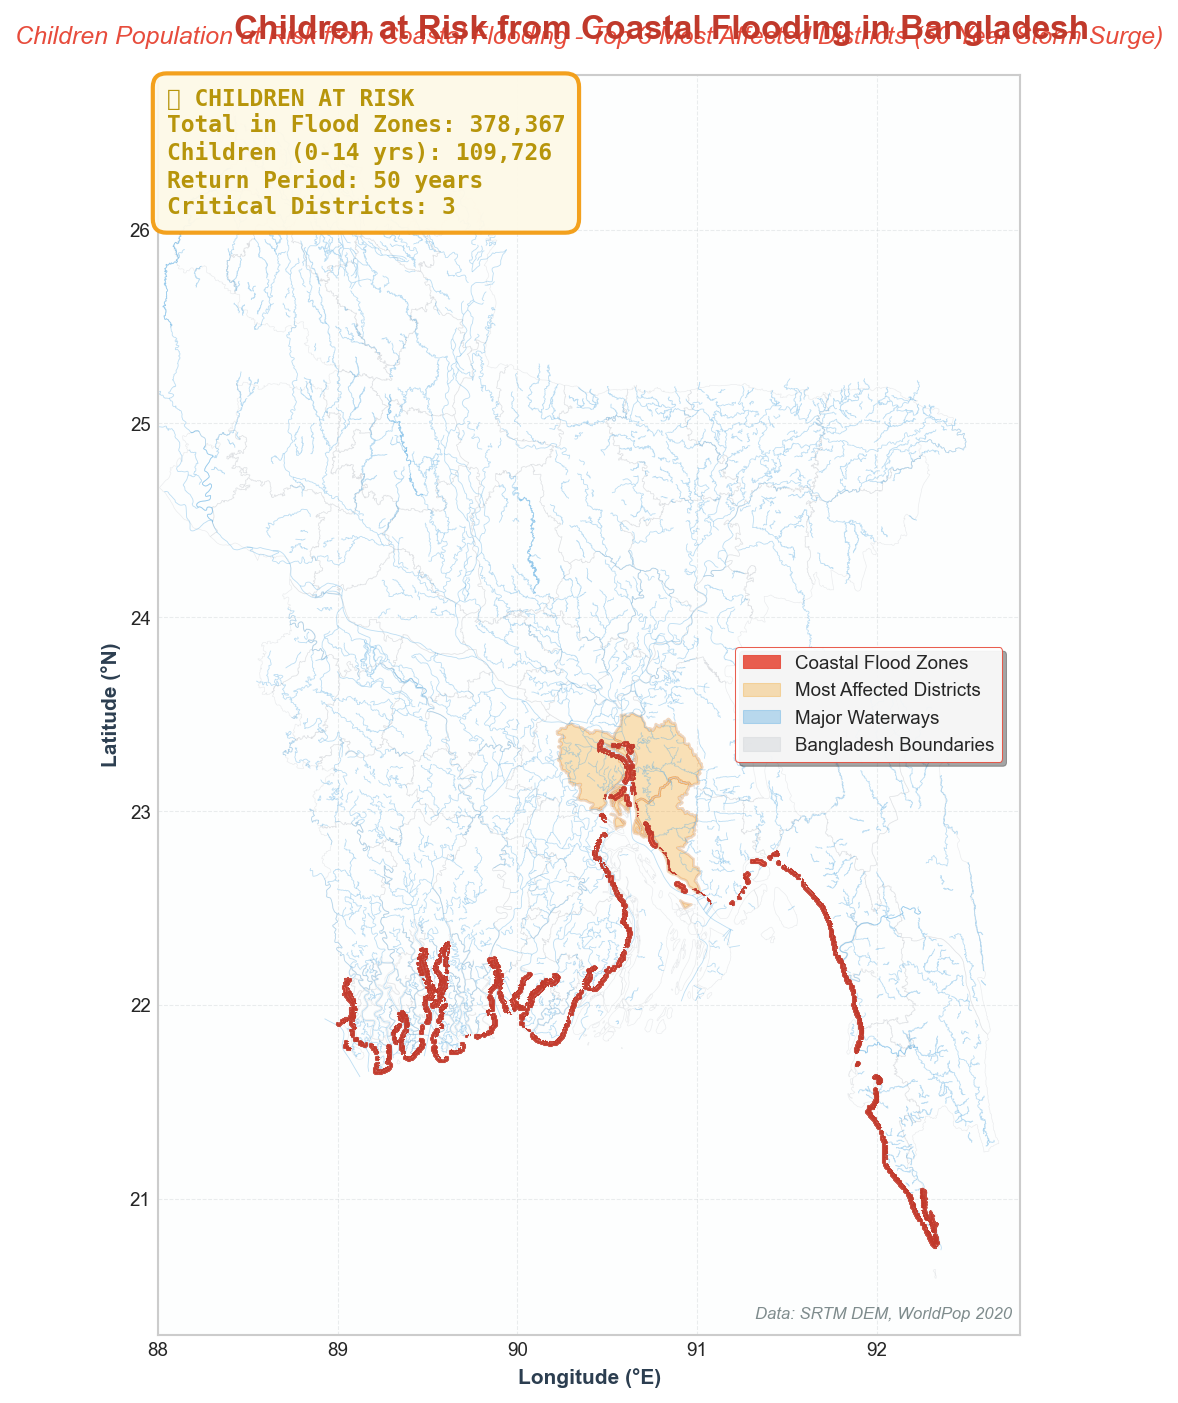

In [28]:
import geopandas as gpd
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.features import rasterize, shapes
from shapely.geometry import box, shape
from shapely.ops import unary_union
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import contextily as ctx
import glob
import numpy as np
from matplotlib.patches import Rectangle
import seaborn as sns

# Set style for better aesthetics
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# ─── 2. DEFINE OTHER DATA PATHS ───────────────────────────────────────────
SURGE_GPKG  = "World_Storm_Surge.gpkg"
ADMIN2_FILE = "adm2.geojson"
POP_RASTER  = "bgd_ppp_2020_constrained.tif"
WATERWAYS   = "hotosm_bgd_waterways_lines_geojson.geojson"
RET_PERIOD  = "T_50"  # can be "T_10","T_25","T_50", etc.
BUFFER_M    = 1000    # buffer surge points by 1 km
DEM_PATH = "srtm_90m_dem_bangladesh_mosaic.tif"

# ─── 3. BUILD AOI FROM ADMIN2 ──────────────────────────────────────────────
admin2 = gpd.read_file(ADMIN2_FILE).to_crs("EPSG:4326")
aoi_poly = unary_union(admin2.geometry)
aoi = gpd.GeoDataFrame(geometry=[aoi_poly], crs="EPSG:4326")

# ─── 4. FULL BANGLADESH MAP WITH COASTAL FLOOD FOCUS ──────────────────────
# Show full Bangladesh bounds - optimized for landscape view
bangladesh_bounds = {
    'minx': 88.0,  # Western border
    'maxx': 92.8,  # Eastern border  
    'miny': 20.3,  # Southern border
    'maxy': 26.8   # Northern border
}

plot_minx = bangladesh_bounds['minx']
plot_maxx = bangladesh_bounds['maxx'] 
plot_miny = bangladesh_bounds['miny']
plot_maxy = bangladesh_bounds['maxy']

# Use coastal area for surge point filtering but show full country
coastal_bbox = box(89.0, 20.5, 92.5, 23.5)

# ─── 5. FILTER SURGE POINTS TO COASTAL AREA ───────────────────────────────
surge = gpd.read_file(SURGE_GPKG).to_crs("EPSG:4326")
surge = surge.cx[coastal_bbox.bounds[0]:coastal_bbox.bounds[2], coastal_bbox.bounds[1]:coastal_bbox.bounds[3]]
surge = surge[surge[RET_PERIOD] > 0]

# ─── 6. BUFFER SURGE POINTS IN UTM, BACK TO DEM CRS ───────────────────────
surge_utm = surge.to_crs(epsg=32646)
surge_utm["buf_geom"] = surge_utm.geometry.buffer(BUFFER_M)
with rasterio.open(DEM_PATH) as dem_src:
    dem_crs = dem_src.crs
surge_buf = surge_utm.set_geometry("buf_geom").to_crs(dem_crs)

# ─── 7. CLIP DEM & POPULATION TO SURGE FOOTPRINT ─────────────────────────
with rasterio.open(DEM_PATH) as dem_src:
    dem_clip, dem_aff = mask(dem_src, [surge_buf.unary_union], crop=True)
    dem = dem_clip[0]
with rasterio.open(POP_RASTER) as pop_src:
    pop_clip, pop_aff = mask(pop_src, [surge_buf.unary_union], crop=True)
    pop = pop_clip[0].astype(float)
    pop[pop == pop_src.nodata] = 0

# ─── 8. RASTERIZE RUN-UP OVER CLIPPED DEM GRID ────────────────────────────
shapes_gen = (
    (geom, runup) for geom, runup in zip(surge_buf.geometry, surge_buf[RET_PERIOD])
)
runup_rast = rasterize(shapes_gen, out_shape=dem.shape, transform=dem_aff,
                       fill=0, all_touched=True, dtype="float32")

# ─── 9. CREATE FLOOD MASK & POLYGONIZE ────────────────────────────────────
flood_mask = (runup_rast >= dem) & (runup_rast > 0)
flood_polys = [
    shape(geom) for geom, val in shapes(flood_mask.astype("uint8"), transform=dem_aff) if val == 1
]
flood_gdf = gpd.GeoDataFrame(geometry=flood_polys, crs=dem_crs).to_crs("EPSG:4326")
flood_bd = flood_gdf[flood_gdf.intersects(aoi_poly)]

# ───10. CALCULATE CHILDREN POPULATION IN FLOOD ZONES ─────────────────────
# Direct flood zone population calculation
stats = zonal_stats(flood_bd.geometry, POP_RASTER, stats=["sum"],
                    nodata=pop_src.nodata, all_touched=True)
direct_pop = sum(s["sum"] or 0 for s in stats)

# Children proportion in Bangladesh is approximately 29%
children_in_flood_zones = direct_pop * 0.29

# Only get the most critically affected districts with significant flood impact
flood_area_threshold = 5e-4  # Higher threshold for only major impacts
critical_districts = admin2[
    admin2.geometry.apply(lambda x: any(x.intersection(flood_poly).area > flood_area_threshold 
                                       for flood_poly in flood_bd.geometry))
]

# Further filter to keep only the top districts by flood intersection area
if len(critical_districts) > 0:
    district_impacts = []
    for idx, district in critical_districts.iterrows():
        total_flood_area = sum(district.geometry.intersection(flood_poly).area 
                             for flood_poly in flood_bd.geometry)
        district_impacts.append((idx, total_flood_area))
    
    # Sort by impact and keep only top 3-5 most affected districts
    district_impacts.sort(key=lambda x: x[1], reverse=True)
    top_district_indices = [idx for idx, _ in district_impacts[:]]  # Keep only top 4
    most_affected_districts = admin2.loc[top_district_indices]
else:
    most_affected_districts = gpd.GeoDataFrame()

print(f"Direct flood zone population: {int(direct_pop):,}")
print(f"Children in direct flood zones: {int(children_in_flood_zones):,}")
print(f"Most critically affected districts: {len(most_affected_districts)}")

# ───11. LANDSCAPE BANGLADESH MAP WITH COASTAL FLOOD FOCUS ─────────────────
water = gpd.read_file(WATERWAYS).to_crs("EPSG:4326")

# Create landscape figure optimized for web embedding
fig, ax = plt.subplots(figsize=(16, 10), dpi=150)  # Landscape: wider than tall, lower DPI for web
fig.patch.set_facecolor('white')

# Show all Bangladesh boundaries lightly
admin2.boundary.plot(ax=ax, color='#D5D8DC', linewidth=0.3, alpha=0.5)

# Filter waterways to full country but show only major ones
water_major = water[water.geometry.length > 0.05] if not water.empty else water

# Plot base layers
# 1. Only the most critically affected districts - highlighted
if not most_affected_districts.empty:
    most_affected_districts.plot(ax=ax, facecolor='#F39C12', alpha=0.3, 
                               edgecolor='#E67E22', linewidth=1.2)

# 2. Major waterways across Bangladesh
if not water_major.empty:
    water_major.plot(ax=ax, color='#5DADE2', linewidth=0.4, alpha=0.4, zorder=2)

# 3. Flood inundation zones - main focus (even though small, visible on full map)
if not flood_bd.empty:
    flood_bd.plot(ax=ax, 
                  facecolor='#E74C3C', 
                  edgecolor='#C0392B', 
                  alpha=0.9, 
                  linewidth=1.0,
                  zorder=3)

# Enhanced annotations focused on children - positioned for landscape layout
stats_text = f"""👶 CHILDREN AT RISK
Total in Flood Zones: {int(direct_pop):,}
Children (0-14 yrs): {int(children_in_flood_zones):,}
Return Period: {RET_PERIOD.replace('T_', '')} years
Critical Districts: {len(most_affected_districts)}"""

# Create a focused text box for children statistics - positioned for landscape
props = dict(boxstyle='round,pad=0.6', facecolor='#FEF9E7', alpha=0.95, 
             edgecolor='#F39C12', linewidth=2)
ax.text(0.01, 0.99, stats_text, 
        transform=ax.transAxes,
        fontsize=11, 
        verticalalignment='top',
        bbox=props,
        fontfamily='monospace',
        weight='bold',
        color='#B7950B')

# Title focused on children impact - adjusted for landscape
fig.suptitle('Children at Risk from Coastal Flooding in Bangladesh', 
             fontsize=16, fontweight='bold', y=0.96, color='#C0392B')
ax.set_title(f'Children Population at Risk from Coastal Flooding - Top {len(most_affected_districts)} Most Affected Districts ({RET_PERIOD.replace("T_", "")} Year Storm Surge)', 
             fontsize=12, pad=15, style='italic', color='#E74C3C')

# Set bounds to show full Bangladesh
ax.set_xlim(plot_minx, plot_maxx)
ax.set_ylim(plot_miny, plot_maxy)

# Enhanced axis labels
ax.set_xlabel('Longitude (°E)', fontsize=10, fontweight='bold', color='#2C3E50')
ax.set_ylabel('Latitude (°N)', fontsize=10, fontweight='bold', color='#2C3E50')

# Minimal grid
ax.grid(True, linestyle='--', alpha=0.3, color='#BDC3C7', linewidth=0.5)
ax.set_facecolor('#FDFEFE')

# Simplified legend for landscape layout - positioned on the right
legend_elements = [
    mpatches.Patch(color='#E74C3C', alpha=0.9, label='Coastal Flood Zones'),
    mpatches.Patch(color='#F39C12', alpha=0.3, label='Most Affected Districts'),
    mpatches.Patch(color='#5DADE2', alpha=0.4, label='Major Waterways'),
    mpatches.Patch(color='#D5D8DC', alpha=0.5, label='Bangladesh Boundaries'),
]

ax.legend(handles=legend_elements, 
          loc='center right', 
          bbox_to_anchor=(0.99, 0.5),
          frameon=True, 
          fancybox=True, 
          shadow=True,
          fontsize=9,
          facecolor='white',
          edgecolor='#E74C3C',
          framealpha=0.9)

# Add data source info for landscape layout - bottom right
source_text = "Data: SRTM DEM, WorldPop 2020"
ax.text(0.99, 0.01, source_text, 
        transform=ax.transAxes,
        fontsize=8, 
        verticalalignment='bottom',
        horizontalalignment='right',
        style='italic',
        color='#7F8C8D')

# Adjust layout for web embedding
plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.06, right=0.88)



print(f"\n👶 CHILDREN AT RISK FROM COASTAL FLOODING 👶")
print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print(f"📍 Focus Area: Direct coastal flood zones only")
print(f"🌊 Storm Surge: {RET_PERIOD.replace('T_', '')} year return period")
print(f"👥 Total Population in Flood Zones: {int(direct_pop):,}")
print(f"👶 Children (0-14) in Flood Zones: {int(children_in_flood_zones):,}")
print(f"🏖️ Directly Affected Districts: {len(most_affected_districts)}")
print(f"🏘️ Flood Zone Polygons: {len(flood_bd)}")
print(f"📊 Analysis: Direct flood zone impact only")
print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")

/var/folders/8c/3ny78wzn60nclfpk9j499zp40000gn/T/ipykernel_14365/2253683131.py:139: UserWarning:

Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/var/folders/8c/3ny78wzn60nclfpk9j499zp40000gn/T/ipykernel_14365/2253683131.py:170: UserWarning:

Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.





CYCLONE AMPHAN INFRASTRUCTURE IMPACT SUMMARY
Hurricane path length: ~200 km
Impact zone: 15 km buffer around hurricane path

Critical Infrastructure Affected:
  🏫 Schools: 385
  🏥 Healthcare facilities: 281
  📊 Total facilities: 666


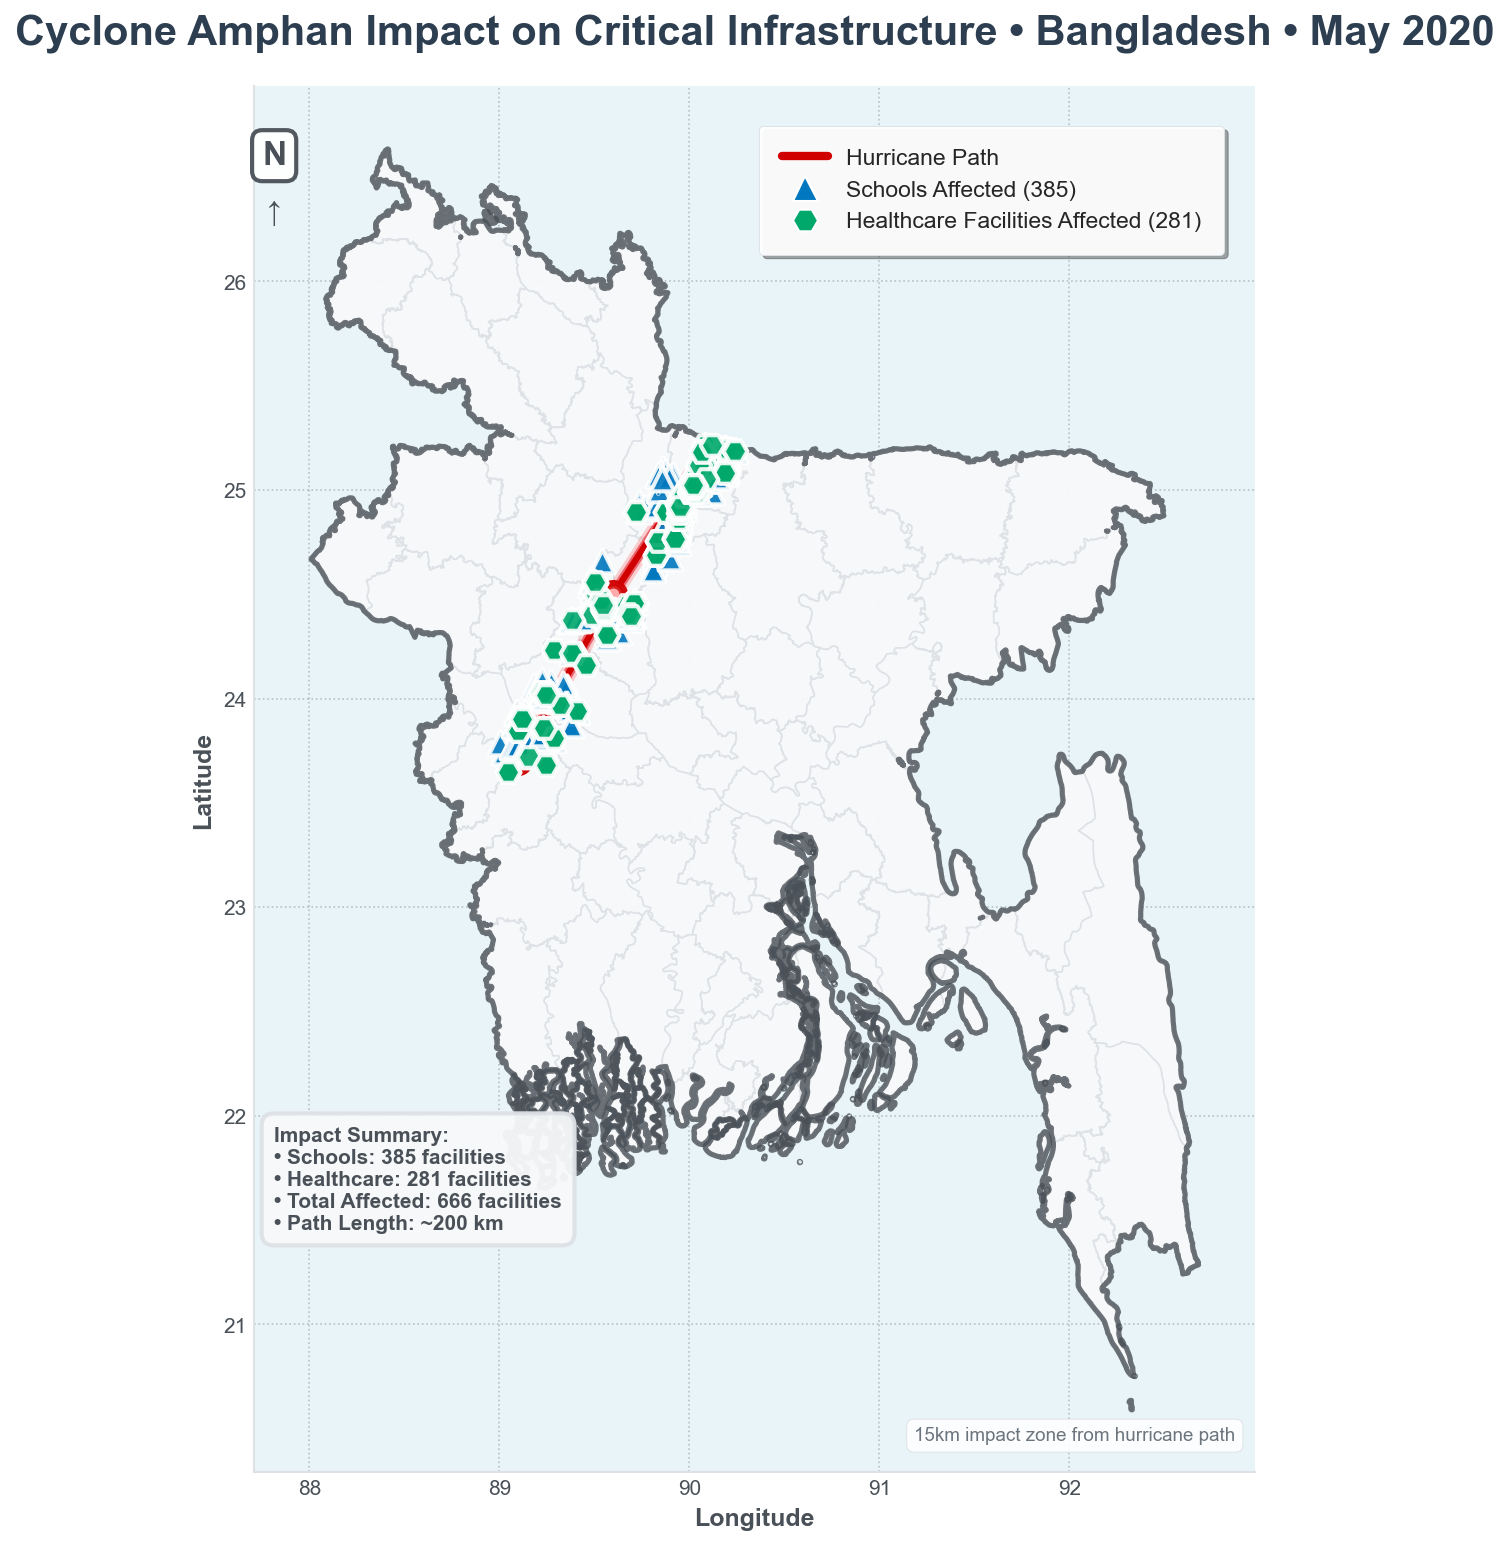

In [29]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from rasterstats import zonal_stats
import rasterio
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

# === Load storm track and AOI ===
track = gpd.read_file("amphan_2020_track.geojson").to_crs("EPSG:4326")
if track.geometry.iloc[0].geom_type == "LineString":
    track = track.explode(index_parts=False).reset_index(drop=True)
aoi = gpd.read_file("aoi_bangladesh.geojson").to_crs("EPSG:4326")
track = gpd.sjoin(track, aoi, predicate="intersects", how="inner")

# === Create swaths for path calculation only ===
track["r34_m"] = track["radius_max_wind"] * 1000
track_utm = track.to_crs(epsg=32646)
track_utm["swath"] = track_utm.buffer(track["r34_m"])
swaths = gpd.overlay(track_utm.set_geometry("swath").to_crs("EPSG:4326"), aoi, how="intersection")

# === Estimate children exposure for filtering ===
POP_RASTER = "bgd_ppp_2020_constrained.tif"
with rasterio.open(POP_RASTER) as src:
    nodata, raster_crs = src.nodata, src.crs
swaths = swaths.to_crs(raster_crs)
stats = zonal_stats(swaths.geometry, POP_RASTER, stats=["sum"], nodata=nodata, all_touched=True)
swaths["children"] = [s["sum"] or 0 for s in stats]
swaths = swaths.to_crs("EPSG:4326").sort_values("time")

# === Filter significant swaths ===
swaths_filtered = swaths[swaths["children"] > 100].copy()

# === Compute storm path ===
swaths_bd = swaths_filtered.to_crs(epsg=32646)
centroids = swaths_bd.geometry.centroid.to_crs("EPSG:4326")
path_gdf = gpd.GeoDataFrame(geometry=[LineString(centroids.tolist())], crs="EPSG:4326") if len(centroids) > 1 else None

# === Create buffer around storm path ===
path_buffer = path_gdf.to_crs(epsg=32646).buffer(15000)  # 15km buffer
path_buffer = gpd.GeoSeries(path_buffer).set_crs(epsg=32646).to_crs("EPSG:4326")

# === Load Admin boundaries ===
admin2 = gpd.read_file("adm2.geojson").to_crs("EPSG:4326")

# === Load and combine health + education ===
health1 = gpd.read_file("healthsites.geojson")
health2 = gpd.read_file("hotosm_bgd_health_facilities_points_geojson.geojson")
health_all = pd.concat([health1, health2], ignore_index=True).to_crs("EPSG:4326")

edu_all = gpd.read_file("hotosm_bgd_education_facilities_points_geojson.geojson").to_crs("EPSG:4326")

# === Facilities near path ===
edu_near_path = edu_all[edu_all.geometry.within(path_buffer[0])]
health_near_path = health_all[health_all.geometry.within(path_buffer[0])]

# === Create landscape map optimized for web ===
fig, ax = plt.subplots(1, 1, figsize=(18, 11), dpi=150)  # Landscape orientation with web-friendly DPI

# Set background color
ax.set_facecolor('#e8f4f8')

# Plot country boundaries with elegant styling
admin2.plot(ax=ax, facecolor='#f8f9fa', edgecolor='#dee2e6', linewidth=0.8, alpha=0.95)

# Add subtle country outline
country_outline = admin2.dissolve()
country_outline.plot(ax=ax, facecolor='none', edgecolor='#495057', linewidth=2.5, alpha=0.8)

# Plot storm path with dramatic styling
if path_gdf is not None:
    # Add path glow effect
    path_gdf.plot(ax=ax, color='#ff6b6b', linewidth=8, alpha=0.3, zorder=3)
    path_gdf.plot(ax=ax, color='#e63946', linewidth=5, alpha=0.7, zorder=4)
    path_gdf.plot(ax=ax, color='#d00000', linewidth=3, linestyle='-', zorder=5)

# Plot storm track points
if len(centroids) > 0:
    ax.scatter(centroids.x, centroids.y, c='#ffffff', s=120, edgecolor='#d00000', 
               linewidth=3, zorder=6, alpha=0.95)
    ax.scatter(centroids.x, centroids.y, c='#ff9999', s=60, edgecolor='#d00000', 
               linewidth=2, zorder=7, alpha=0.8)

# Plot facilities with beautiful markers
# Education facilities - Blue academic theme
edu_near_path.plot(ax=ax, marker='^', color='#0077be', markersize=130,
                   edgecolor='white', linewidth=2, zorder=8, alpha=0.9)

# Health facilities - Green medical theme  
health_near_path.plot(ax=ax, marker='H', color='#00a86b', markersize=130,
                      edgecolor='white', linewidth=2, zorder=8, alpha=0.9)

# Set map extent to show full Bangladesh with landscape-friendly padding
bounds_padding = 0.3  # Reduced padding for landscape
ax.set_xlim(admin2.total_bounds[0] - bounds_padding, admin2.total_bounds[2] + bounds_padding)
ax.set_ylim(admin2.total_bounds[1] - bounds_padding, admin2.total_bounds[3] + bounds_padding)

# Beautiful title - adjusted for landscape
ax.set_title("Cyclone Amphan Impact on Critical Infrastructure • Bangladesh • May 2020", 
             fontsize=20, fontweight='bold', pad=20, color='#2c3e50')

# Clean axis labels
ax.set_xlabel("Longitude", fontsize=12, fontweight='bold', color='#495057')
ax.set_ylabel("Latitude", fontsize=12, fontweight='bold', color='#495057')

# Elegant grid
ax.grid(True, linestyle=':', linewidth=0.8, alpha=0.4, color='#6c757d')

# Create custom legend - positioned for landscape layout
legend_elements = [
    plt.Line2D([0], [0], color='#d00000', linewidth=4, label=f'Hurricane Path'),
    plt.Line2D([0], [0], marker='^', color='#0077be', linewidth=0, markersize=12, 
               markeredgecolor='white', markeredgewidth=1, label=f'Schools Affected ({len(edu_near_path)})'),
    plt.Line2D([0], [0], marker='H', color='#00a86b', linewidth=0, markersize=12,
               markeredgecolor='white', markeredgewidth=1, label=f'Healthcare Facilities Affected ({len(health_near_path)})')
]

# Position legend in upper right for landscape
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98),
          frameon=True, fancybox=True, shadow=True, fontsize=11, framealpha=0.95, 
          facecolor='white', edgecolor='#dee2e6', borderpad=1)

# Add north arrow with style - repositioned for landscape
arrow_props = dict(boxstyle='round,pad=0.3', facecolor='white', 
                   edgecolor='#495057', linewidth=2, alpha=0.95)
ax.annotate('N', xy=(0.02, 0.95), xycoords='axes fraction',
            fontsize=16, fontweight='bold', ha='center', va='center',
            bbox=arrow_props, color='#495057')
ax.annotate('↑', xy=(0.02, 0.91), xycoords='axes fraction',
            fontsize=14, ha='center', va='center', color='#495057')

# Add summary statistics box - repositioned for landscape layout
stats_text = f"""Impact Summary:
• Schools: {len(edu_near_path)} facilities
• Healthcare: {len(health_near_path)} facilities  
• Total Affected: {len(edu_near_path) + len(health_near_path)} facilities
• Path Length: ~{int(path_gdf.length.iloc[0] * 111)} km"""

ax.text(0.02, 0.25, stats_text, transform=ax.transAxes, 
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(boxstyle='round,pad=0.6', facecolor='#f8f9fa', 
                  edgecolor='#dee2e6', linewidth=2, alpha=0.95), 
        fontsize=10, color='#495057', fontweight='bold')

# Add scale indicator - repositioned for landscape
ax.text(0.98, 0.02, "15km impact zone from hurricane path", 
        transform=ax.transAxes, verticalalignment='bottom', 
        horizontalalignment='right', fontsize=9, color='#6c757d',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                  edgecolor='#dee2e6', alpha=0.9))

# Clean up appearance
ax.tick_params(colors='#495057', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('#dee2e6')
ax.spines['left'].set_color('#dee2e6')

# Optimize layout for landscape web embedding
plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.06, right=0.94)


# === Summary Statistics ===
print("\n" + "="*70)
print("CYCLONE AMPHAN INFRASTRUCTURE IMPACT SUMMARY")
print("="*70)
print(f"Hurricane path length: ~{int(path_gdf.length.iloc[0] * 111)} km")
print(f"Impact zone: 15 km buffer around hurricane path")
print(f"")
print(f"Critical Infrastructure Affected:")
print(f"  🏫 Schools: {len(edu_near_path)}")
print(f"  🏥 Healthcare facilities: {len(health_near_path)}")
print(f"  📊 Total facilities: {len(edu_near_path) + len(health_near_path)}")
print("="*70)